In [103]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns

from scipy.stats import pearsonr
from scipy.stats import linregress

import yfinance as yf

import warnings
warnings.filterwarnings("ignore")

from datetime import datetime
import datetime as dt
import time

## Upload provided XL file

In [104]:
import os

# Corrected path - remove the duplicate 09_projects and use correct filename
path = os.path.abspath(os.path.join("..", "01_The Unintended Consequences of Rebalancing", "SPY_TLT_Cleaned.xlsx"))

# Alternative: If you're already in the correct directory, try direct path
# path = "SPY_TLT_Cleaned.xlsx"

# Check if file exists before reading
if not os.path.exists(path):
    print(f"File not found")
    print("Current working directory:", os.getcwd())
    print("Available files in current directory:")
    current_dir = os.path.dirname(path)
    if os.path.exists(current_dir):
        for item in os.listdir(current_dir):
            if item.endswith('.xlsx'):
                print(f"  - {item}")
    else:
        print("Directory doesn't exist")
        # Try alternative paths
        alternative_paths = [
            "SPY_TLT_Cleaned.xlsx",
            os.path.join(".", "SPY_TLT_Cleaned.xlsx"),
            os.path.abspath("SPY_TLT_Cleaned.xlsx")
        ]
        for alt_path in alternative_paths:
            if os.path.exists(alt_path):
                print(f"Found file at alternative path: {alt_path}")
                path = alt_path
                break
else:
    print(f"File found")

# Read the Excel file
if os.path.exists(path):
    df = pd.read_excel(path)
    print("DataFrame loaded successfully!")
    print(f"Shape: {df.shape}")
    print("\nFirst 5 rows:")
    print(df.head())
else:
    print("Could not locate the Excel file. Please check the file location.")

File found
DataFrame loaded successfully!
Shape: (281, 4)

First 5 rows:
            Unnamed: 0                      Unnamed: 1  \
0                  NaN                             NaN   
1                 Date  Sum of SPY - TLT First 15 Days   
2  2002-08-01 00:00:00                        0.010151   
3  2002-09-01 00:00:00                       -0.126546   
4  2002-10-01 00:00:00                        0.160759   

                   Unnamed: 2                              Unnamed: 3  
0                         NaN                                     NaN  
1  Sum of SPY-TLT Last 5 Days  Sum of SPY-TLT First 5 Days Next Month  
2                   -0.057039                               -0.019438  
3                   -0.025929                               -0.028645  
4                   -0.044043                                0.009031  


In [105]:
# rename columns to Date	Sum of SPY - TLT First 15 Days	Sum of SPY-TLT Last 5 Days	Sum of SPY-TLT First 5 Days Next Month
df.columns = ['Date', 'Sum of SPY - TLT First 15 Days', 'Sum of SPY - TLT Last 5 Days', 'Sum of SPY - TLT First 5 Days Next Month']

# drop rows 0 to 1 (nan and objects)
df = df.drop(index=[0, 1])

# drop row index 280 (sum values of original data)
df = df.drop(index=[280])

# column Date has dtype object, extract date with slice and convert to datetime
df['Date'] = pd.to_datetime(df['Date'].astype(str).str.slice(0, 10))

# convert other columns to float
df['Sum of SPY - TLT First 15 Days'] = df['Sum of SPY - TLT First 15 Days'].astype(float)
df['Sum of SPY - TLT Last 5 Days'] = df['Sum of SPY - TLT Last 5 Days'].astype(float)
df['Sum of SPY - TLT First 5 Days Next Month'] = df['Sum of SPY - TLT First 5 Days Next Month'].astype(float)

# set Date as index
df = df.set_index('Date')

# rename index to date
df.index.name = 'date'

# column names to lowercase and replace spaces with underscores
df.columns = [col.lower().replace(' ', '_').replace('-', '') for col in df.columns]

In [106]:
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 278 entries, 2002-08-01 to 2025-09-01
Data columns (total 3 columns):
 #   Column                                   Non-Null Count  Dtype  
---  ------                                   --------------  -----  
 0   sum_of_spy__tlt_first_15_days            278 non-null    float64
 1   sum_of_spy__tlt_last_5_days              278 non-null    float64
 2   sum_of_spy__tlt_first_5_days_next_month  278 non-null    float64
dtypes: float64(3)
memory usage: 8.7 KB


In [107]:
df.tail()

,sum_of_spy__tlt_first_15_days,sum_of_spy__tlt_last_5_days,sum_of_spy__tlt_first_5_days_next_month
date,,,
2025-05-01,0.109579,-0.015997,0.023529
2025-06-01,0.011664,0.012153,0.025776
2025-07-01,0.033737,0.000495,-0.012138
2025-08-01,0.007544,0.012641,-0.033569
2025-09-01,0.008236,-0.008515,0.003057


In [108]:
df.columns  

Index(['sum_of_spy__tlt_first_15_days', 'sum_of_spy__tlt_last_5_days',
       'sum_of_spy__tlt_first_5_days_next_month'],
      dtype='object')

## Create new dfs, for scatter plot analysis

In [109]:
monthly_periods = df.copy()

In [110]:
first_15_days = monthly_periods.sum_of_spy__tlt_first_15_days
remaining_days = monthly_periods.sum_of_spy__tlt_last_5_days
next_month_first_5 = monthly_periods.sum_of_spy__tlt_first_5_days_next_month

# print head of each df, to check data
print("First 15 Days Periods:")
print(first_15_days.head())
print("\nRemaining Days Periods:")
print(remaining_days.head())
print("\nNext Month First 5 Days Periods:")
print(next_month_first_5.head())

First 15 Days Periods:
date
2002-08-01    0.010151
2002-09-01   -0.126546
2002-10-01    0.160759
2002-11-01    0.063586
2002-12-01   -0.064205
Name: sum_of_spy__tlt_first_15_days, dtype: float64

Remaining Days Periods:
date
2002-08-01   -0.057039
2002-09-01   -0.025929
2002-10-01   -0.044043
2002-11-01    0.005471
2002-12-01   -0.038289
Name: sum_of_spy__tlt_last_5_days, dtype: float64

Next Month First 5 Days Periods:
date
2002-08-01   -0.019438
2002-09-01   -0.028645
2002-10-01    0.009031
2002-11-01   -0.032746
2002-12-01    0.053190
Name: sum_of_spy__tlt_first_5_days_next_month, dtype: float64


In [111]:
# every column should have name diff_cumsum_final to keep consistent naming
first_15_days.name = 'diff_cumsum_final'
remaining_days.name = 'diff_cumsum_final'
next_month_first_5.name = 'diff_cumsum_final'

# convert to DataFrames
first_15_days = first_15_days.to_frame()
remaining_days = remaining_days.to_frame()
next_month_first_5 = next_month_first_5.to_frame()

In [112]:
first_15_days.head()

,diff_cumsum_final
date,
2002-08-01,0.010151
2002-09-01,-0.126546
2002-10-01,0.160759
2002-11-01,0.063586
2002-12-01,-0.064205


In [113]:
# Compare data (diff_cumsum_final) from the three periods with the excel sheet provided
# sum of diff_cumsum_final from the three periods should match the excel sheet values
first_15_days_sum = first_15_days['diff_cumsum_final'].sum()
remaining_days_sum = remaining_days['diff_cumsum_final'].sum()
next_month_first_5_sum = next_month_first_5['diff_cumsum_final'].sum()

# print the values
print(f"\nSum of diff_cumsum_final for First 15 Days: {first_15_days_sum:.6f}")
print(f"Sum of diff_cumsum_final for Remaining Days: {remaining_days_sum:.6f}")
print(f"Sum of diff_cumsum_final for Next Month First 5 Days: {next_month_first_5_sum:.6f}")


Sum of diff_cumsum_final for First 15 Days: 2.033446
Sum of diff_cumsum_final for Remaining Days: -0.479423
Sum of diff_cumsum_final for Next Month First 5 Days: 1.635966


In [114]:
# analyze diff_cumsum_final using describe() method
print("\nDescriptive Statistics for diff_cumsum_final in First 15 Days:")
print(first_15_days['diff_cumsum_final'].describe())
print("\nDescriptive Statistics for diff_cumsum_final in Remaining Days:")
print(remaining_days['diff_cumsum_final'].describe())
print("\nDescriptive Statistics for diff_cumsum_final in Next Month First 5 Days:")
print(next_month_first_5['diff_cumsum_final'].describe())


Descriptive Statistics for diff_cumsum_final in First 15 Days:
count    278.000000
mean       0.007315
std        0.063824
min       -0.304124
25%       -0.021051
50%        0.014770
75%        0.043702
max        0.160759
Name: diff_cumsum_final, dtype: float64

Descriptive Statistics for diff_cumsum_final in Remaining Days:
count    278.000000
mean      -0.001725
std        0.031025
min       -0.119944
25%       -0.019197
50%       -0.001004
75%        0.016365
max        0.119846
Name: diff_cumsum_final, dtype: float64

Descriptive Statistics for diff_cumsum_final in Next Month First 5 Days:
count    278.000000
mean       0.005885
std        0.038677
min       -0.192288
25%       -0.013431
50%        0.010453
75%        0.030533
max        0.093695
Name: diff_cumsum_final, dtype: float64


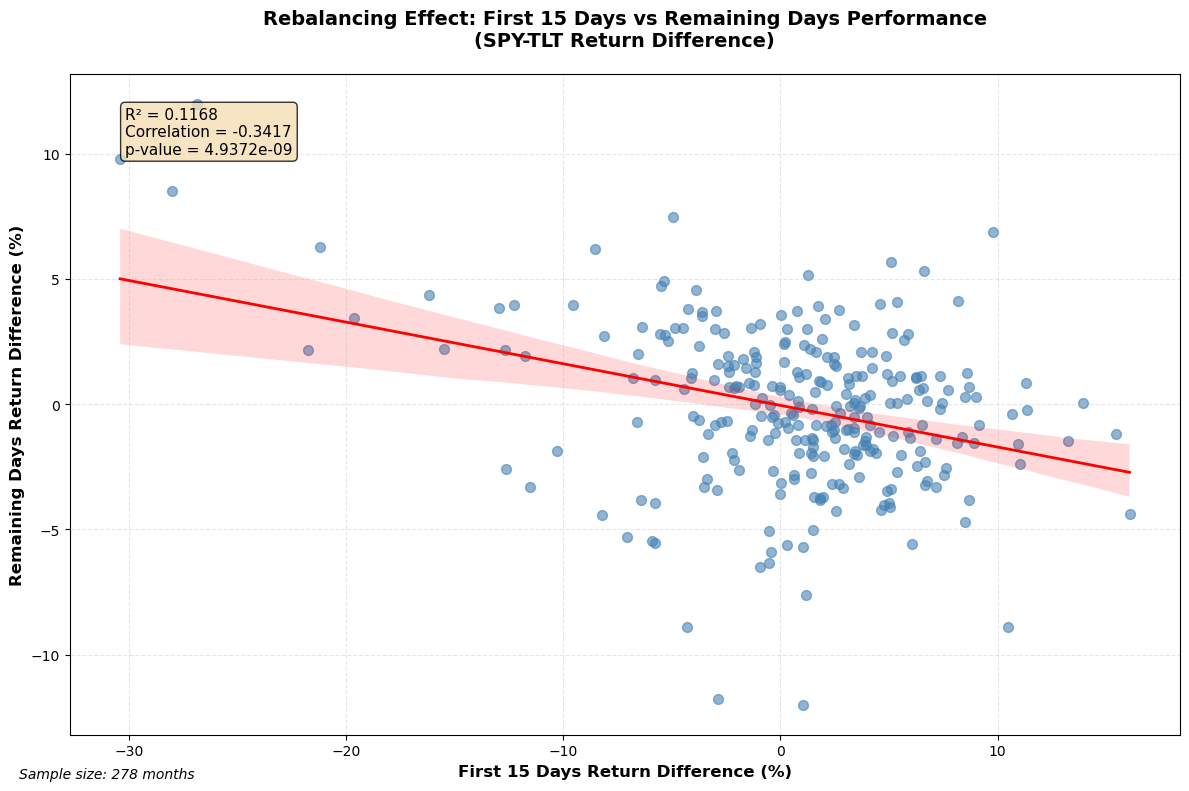


REBALANCING CORRELATION ANALYSIS
Sample size: 278 months
Correlation coefficient: -0.3417
R-squared: 0.1168
P-value: 4.9372e-09
Statistical significance: Yes (α = 0.05)

Interpretation:
• Moderate negative correlation between early and late month performance
• 11.7% of variance in remaining days explained by first 15 days


In [115]:
# Scatter plot: First 15 Days vs Remaining Days Performance
plt.figure(figsize=(12, 8))

# Create the regression plot
ax = sns.regplot(
    x=first_15_days['diff_cumsum_final'] * 100, 
    y=remaining_days['diff_cumsum_final'] * 100,
    scatter_kws={'alpha': 0.6, 'color': 'steelblue', 's': 50},
    line_kws={'color': 'red', 'linewidth': 2}
)

# Calculate R-squared
x_data = first_15_days['diff_cumsum_final'] * 100
y_data = remaining_days['diff_cumsum_final'] * 100
correlation, p_value = pearsonr(x_data, y_data)
r_squared = correlation ** 2

# Add proper titles and labels
plt.title('Rebalancing Effect: First 15 Days vs Remaining Days Performance\n(SPY-TLT Return Difference)', 
          fontsize=14, fontweight='bold', pad=20)
plt.xlabel('First 15 Days Return Difference (%)', fontsize=12, fontweight='bold')
plt.ylabel('Remaining Days Return Difference (%)', fontsize=12, fontweight='bold')

# Add R-squared annotation
plt.text(0.05, 0.95, f'R² = {r_squared:.4f}\nCorrelation = {correlation:.4f}\np-value = {p_value:.4e}', 
         transform=ax.transAxes, fontsize=11, verticalalignment='top',
         bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.8))

# Add grid for better readability
plt.grid(True, alpha=0.3, linestyle='--')

# Improve layout
plt.tight_layout()

# Add summary statistics
n_observations = len(x_data)
plt.figtext(0.02, 0.02, f'Sample size: {n_observations} months', 
            fontsize=10, style='italic')

plt.show()

# Print summary statistics
print("\n" + "="*60)
print("REBALANCING CORRELATION ANALYSIS")
print("="*60)
print(f"Sample size: {n_observations} months")
print(f"Correlation coefficient: {correlation:.4f}")
print(f"R-squared: {r_squared:.4f}")
print(f"P-value: {p_value:.4e}")
print(f"Statistical significance: {'Yes' if p_value < 0.05 else 'No'} (α = 0.05)")
print("\nInterpretation:")
if abs(correlation) > 0.7:
    strength = "Strong"
elif abs(correlation) > 0.3:
    strength = "Moderate"
else:
    strength = "Weak"
direction = "positive" if correlation > 0 else "negative"
print(f"• {strength} {direction} correlation between early and late month performance")
print(f"• {r_squared*100:.1f}% of variance in remaining days explained by first 15 days")
print("="*60)

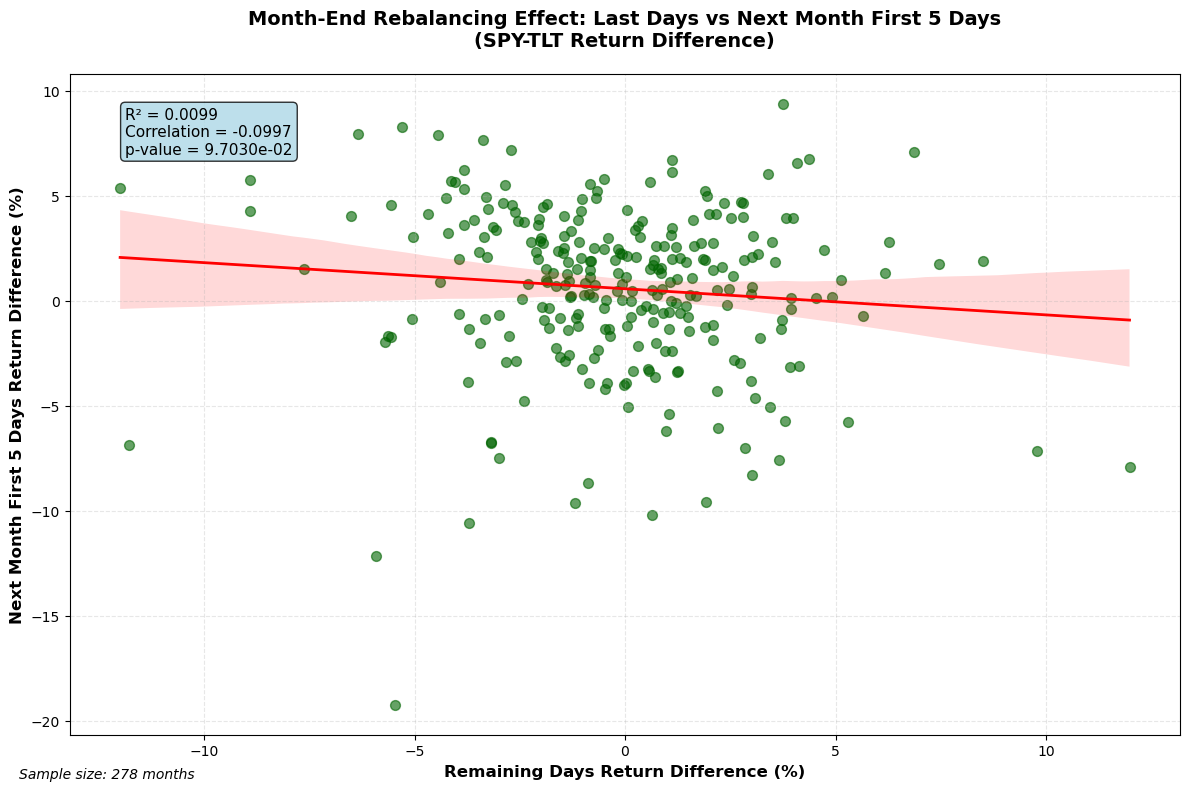


MONTH-END REBALANCING CORRELATION ANALYSIS
Sample size: 278 months
Correlation coefficient: -0.0997
R-squared: 0.0099
P-value: 9.7030e-02
Statistical significance: No (α = 0.05)

Interpretation:
• Weak negative correlation between month-end and next month beginning
• 1.0% of variance in next month's first 5 days explained by current month's end


In [116]:
# Scatter plot: Last Days vs First 5 Days of Next Month
# For File 4 (Excel source), we don't need complex alignment since data is already properly structured

# Since we're working with Excel data that's already aligned by month,
# we can directly use the data without year/month matching
x_data = remaining_days['diff_cumsum_final'].values * 100
y_data = next_month_first_5['diff_cumsum_final'].values * 100

# Remove NaN values if any exist
mask = ~(pd.isna(x_data) | pd.isna(y_data))
x_data = x_data[mask]
y_data = y_data[mask]

plt.figure(figsize=(12, 8))

# Create the regression plot
ax = sns.regplot(
    x=x_data, 
    y=y_data,
    scatter_kws={'alpha': 0.6, 'color': 'darkgreen', 's': 50},
    line_kws={'color': 'red', 'linewidth': 2}
)

# Calculate R-squared
correlation, p_value = pearsonr(x_data, y_data)
r_squared = correlation ** 2

# Add proper titles and labels
plt.title('Month-End Rebalancing Effect: Last Days vs Next Month First 5 Days\n(SPY-TLT Return Difference)', 
          fontsize=14, fontweight='bold', pad=20)
plt.xlabel('Remaining Days Return Difference (%)', fontsize=12, fontweight='bold')
plt.ylabel('Next Month First 5 Days Return Difference (%)', fontsize=12, fontweight='bold')

# Add R-squared annotation
plt.text(0.05, 0.95, f'R² = {r_squared:.4f}\nCorrelation = {correlation:.4f}\np-value = {p_value:.4e}', 
         transform=ax.transAxes, fontsize=11, verticalalignment='top',
         bbox=dict(boxstyle='round', facecolor='lightblue', alpha=0.8))

# Add grid for better readability
plt.grid(True, alpha=0.3, linestyle='--')

# Improve layout
plt.tight_layout()

# Add summary statistics
n_observations = len(x_data)
plt.figtext(0.02, 0.02, f'Sample size: {n_observations} months', 
            fontsize=10, style='italic')

plt.show()

# Print summary statistics
print("\n" + "="*60)
print("MONTH-END REBALANCING CORRELATION ANALYSIS")
print("="*60)
print(f"Sample size: {n_observations} months")
print(f"Correlation coefficient: {correlation:.4f}")
print(f"R-squared: {r_squared:.4f}")
print(f"P-value: {p_value:.4e}")
print(f"Statistical significance: {'Yes' if p_value < 0.05 else 'No'} (α = 0.05)")
print("\nInterpretation:")
if abs(correlation) > 0.7:
    strength = "Strong"
elif abs(correlation) > 0.3:
    strength = "Moderate"
else:
    strength = "Weak"
direction = "positive" if correlation > 0 else "negative"
print(f"• {strength} {direction} correlation between month-end and next month beginning")
print(f"• {r_squared*100:.1f}% of variance in next month's first 5 days explained by current month's end")
print("="*60)

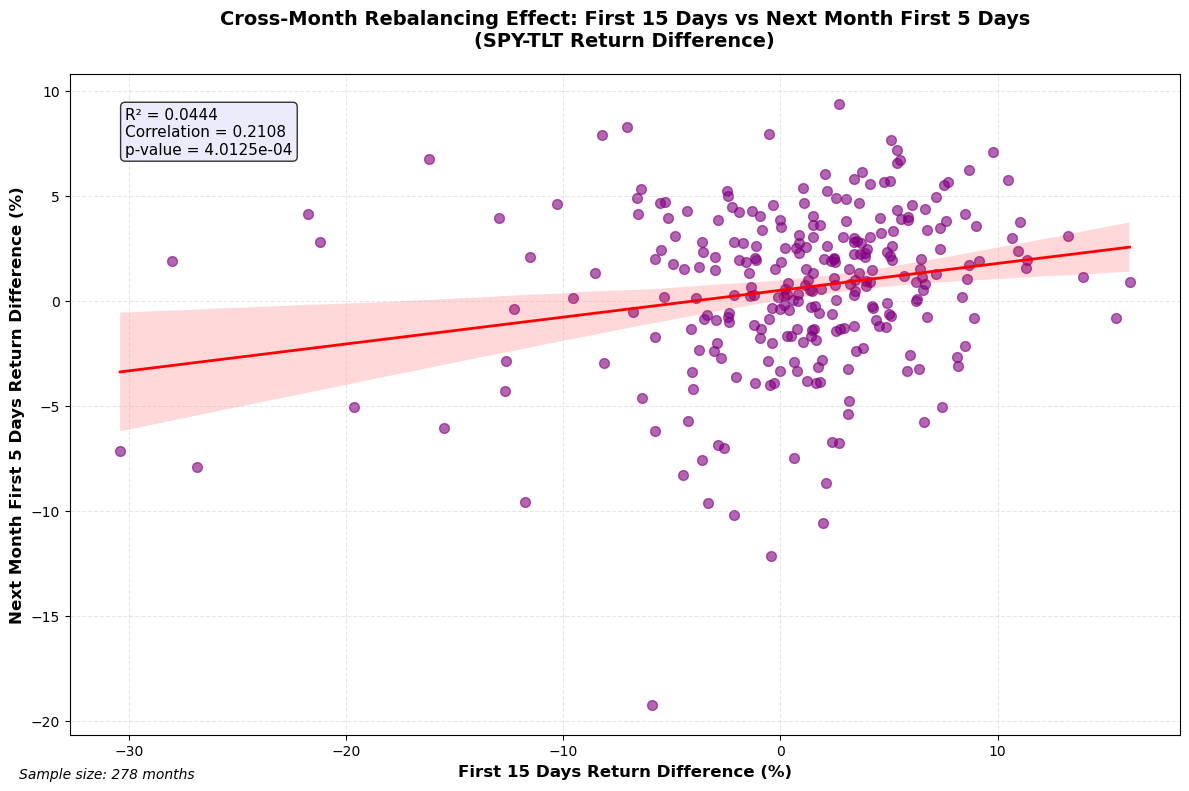


CROSS-MONTH REBALANCING CORRELATION ANALYSIS
Sample size: 278 months
Correlation coefficient: 0.2108
R-squared: 0.0444
P-value: 4.0125e-04
Statistical significance: Yes (α = 0.05)

Interpretation:
• Weak positive correlation between early month and next month beginning
• 4.4% of variance in next month's first 5 days explained by current month's first 15 days


In [117]:
# Scatter plot: First 15 Days vs First 5 Days of Next Month
# For File 4 (Excel source), we don't need complex alignment since data is already properly structured

# Since we're working with Excel data that's already aligned by month,
# we can directly use the data without year/month matching
x_data = first_15_days['diff_cumsum_final'].values * 100
y_data = next_month_first_5['diff_cumsum_final'].values * 100

# Remove NaN values if any exist
mask = ~(pd.isna(x_data) | pd.isna(y_data))
x_data = x_data[mask]
y_data = y_data[mask]

plt.figure(figsize=(12, 8))

# Create the regression plot
ax = sns.regplot(
    x=x_data, 
    y=y_data,
    scatter_kws={'alpha': 0.6, 'color': 'purple', 's': 50},
    line_kws={'color': 'red', 'linewidth': 2}
)

# Calculate R-squared
correlation, p_value = pearsonr(x_data, y_data)
r_squared = correlation ** 2

# Add proper titles and labels
plt.title('Cross-Month Rebalancing Effect: First 15 Days vs Next Month First 5 Days\n(SPY-TLT Return Difference)', 
          fontsize=14, fontweight='bold', pad=20)
plt.xlabel('First 15 Days Return Difference (%)', fontsize=12, fontweight='bold')
plt.ylabel('Next Month First 5 Days Return Difference (%)', fontsize=12, fontweight='bold')

# Add R-squared annotation
plt.text(0.05, 0.95, f'R² = {r_squared:.4f}\nCorrelation = {correlation:.4f}\np-value = {p_value:.4e}', 
         transform=ax.transAxes, fontsize=11, verticalalignment='top',
         bbox=dict(boxstyle='round', facecolor='lavender', alpha=0.8))

# Add grid for better readability
plt.grid(True, alpha=0.3, linestyle='--')

# Improve layout
plt.tight_layout()

# Add summary statistics
n_observations = len(x_data)
plt.figtext(0.02, 0.02, f'Sample size: {n_observations} months', 
            fontsize=10, style='italic')

plt.show()

# Print summary statistics
print("\n" + "="*60)
print("CROSS-MONTH REBALANCING CORRELATION ANALYSIS")
print("="*60)
print(f"Sample size: {n_observations} months")
print(f"Correlation coefficient: {correlation:.4f}")
print(f"R-squared: {r_squared:.4f}")
print(f"P-value: {p_value:.4e}")
print(f"Statistical significance: {'Yes' if p_value < 0.05 else 'No'} (α = 0.05)")
print("\nInterpretation:")
if abs(correlation) > 0.7:
    strength = "Strong"
elif abs(correlation) > 0.3:
    strength = "Moderate"
else:
    strength = "Weak"
direction = "positive" if correlation > 0 else "negative"
print(f"• {strength} {direction} correlation between early month and next month beginning")
print(f"• {r_squared*100:.1f}% of variance in next month's first 5 days explained by current month's first 15 days")
print("="*60)

## Overall Data verification

In [118]:
print("VERIFICATION OF R² AND CORRELATION CALCULATIONS")
print("="*80)

# Case 1: First 15 Days vs Remaining Days
print("\n1. FIRST 15 DAYS vs REMAINING DAYS")
print("-" * 50)

x1_data = first_15_days['diff_cumsum_final'] * 100
y1_data = remaining_days['diff_cumsum_final'] * 100

# Current method (Pearson correlation)
correlation1, p_value1 = pearsonr(x1_data, y1_data)
r_squared1_current = correlation1 ** 2

# Verification with linregress
slope1, intercept1, r_value1, p_value1_lr, std_err1 = linregress(x1_data, y1_data)
r_squared1_linregress = r_value1 ** 2

print(f"Pearson correlation:     {correlation1:.6f}")
print(f"Linregress correlation:  {r_value1:.6f}")
print(f"Correlation difference:  {abs(correlation1 - r_value1):.10f}")
print(f"Correlation match: {'✓ YES' if abs(correlation1 - r_value1) < 1e-10 else '✗ NO'}")
print(f"Current method R²:       {r_squared1_current:.6f}")
print(f"Linregress R²:           {r_squared1_linregress:.6f}")
print(f"R² difference:           {abs(r_squared1_current - r_squared1_linregress):.10f}")
print(f"R² match: {'✓ YES' if abs(r_squared1_current - r_squared1_linregress) < 1e-10 else '✗ NO'}")

# Case 2: Last Days vs First 5 Days of Next Month
print("\n2. LAST DAYS vs FIRST 5 DAYS NEXT MONTH")
print("-" * 50)

# For Excel data, use direct alignment without year/month matching
x2_data = remaining_days['diff_cumsum_final'].values * 100
y2_data = next_month_first_5['diff_cumsum_final'].values * 100

# Remove NaN values if any exist
mask = ~(pd.isna(x2_data) | pd.isna(y2_data))
x2_data = x2_data[mask]
y2_data = y2_data[mask]

# Current method (Pearson correlation)
correlation2, p_value2 = pearsonr(x2_data, y2_data)
r_squared2_current = correlation2 ** 2

# Verification with linregress
slope2, intercept2, r_value2, p_value2_lr, std_err2 = linregress(x2_data, y2_data)
r_squared2_linregress = r_value2 ** 2

print(f"Pearson correlation:     {correlation2:.6f}")
print(f"Linregress correlation:  {r_value2:.6f}")
print(f"Correlation difference:  {abs(correlation2 - r_value2):.10f}")
print(f"Correlation match: {'✓ YES' if abs(correlation2 - r_value2) < 1e-10 else '✗ NO'}")
print(f"Current method R²:       {r_squared2_current:.6f}")
print(f"Linregress R²:           {r_squared2_linregress:.6f}")
print(f"R² difference:           {abs(r_squared2_current - r_squared2_linregress):.10f}")
print(f"R² match: {'✓ YES' if abs(r_squared2_current - r_squared2_linregress) < 1e-10 else '✗ NO'}")

# Case 3: First 15 Days vs First 5 Days of Next Month
print("\n3. FIRST 15 DAYS vs FIRST 5 DAYS NEXT MONTH")
print("-" * 50)

# For Excel data, use direct alignment without year/month matching
x3_data = first_15_days['diff_cumsum_final'].values * 100
y3_data = next_month_first_5['diff_cumsum_final'].values * 100

# Remove NaN values if any exist
mask = ~(pd.isna(x3_data) | pd.isna(y3_data))
x3_data = x3_data[mask]
y3_data = y3_data[mask]

# Current method (Pearson correlation)
correlation3, p_value3 = pearsonr(x3_data, y3_data)
r_squared3_current = correlation3 ** 2

# Verification with linregress
slope3, intercept3, r_value3, p_value3_lr, std_err3 = linregress(x3_data, y3_data)
r_squared3_linregress = r_value3 ** 2

print(f"Pearson correlation:     {correlation3:.6f}")
print(f"Linregress correlation:  {r_value3:.6f}")
print(f"Correlation difference:  {abs(correlation3 - r_value3):.10f}")
print(f"Correlation match: {'✓ YES' if abs(correlation3 - r_value3) < 1e-10 else '✗ NO'}")
print(f"Current method R²:       {r_squared3_current:.6f}")
print(f"Linregress R²:           {r_squared3_linregress:.6f}")
print(f"R² difference:           {abs(r_squared3_current - r_squared3_linregress):.10f}")
print(f"R² match: {'✓ YES' if abs(r_squared3_current - r_squared3_linregress) < 1e-10 else '✗ NO'}")

# Summary comparison tables
print("\n" + "="*80)
print("CORRELATION COMPARISON TABLE")
print("="*80)
print(f"{'Analysis':<40} {'Pearson r':<12} {'Linregress r':<12} {'Match':<8}")
print("-" * 80)
print(f"{'First 15 vs Remaining Days':<40} {correlation1:<12.6f} {r_value1:<12.6f} {'✓' if abs(correlation1 - r_value1) < 1e-10 else '✗':<8}")
print(f"{'Last Days vs Next Month First 5':<40} {correlation2:<12.6f} {r_value2:<12.6f} {'✓' if abs(correlation2 - r_value2) < 1e-10 else '✗':<8}")
print(f"{'First 15 vs Next Month First 5':<40} {correlation3:<12.6f} {r_value3:<12.6f} {'✓' if abs(correlation3 - r_value3) < 1e-10 else '✗':<8}")

print("\n" + "="*80)
print("R² COMPARISON TABLE")
print("="*80)
print(f"{'Analysis':<40} {'Current R²':<12} {'Linregress R²':<12} {'Match':<8}")
print("-" * 80)
print(f"{'First 15 vs Remaining Days':<40} {r_squared1_current:<12.6f} {r_squared1_linregress:<12.6f} {'✓' if abs(r_squared1_current - r_squared1_linregress) < 1e-10 else '✗':<8}")
print(f"{'Last Days vs Next Month First 5':<40} {r_squared2_current:<12.6f} {r_squared2_linregress:<12.6f} {'✓' if abs(r_squared2_current - r_squared2_linregress) < 1e-10 else '✗':<8}")
print(f"{'First 15 vs Next Month First 5':<40} {r_squared3_current:<12.6f} {r_squared3_linregress:<12.6f} {'✓' if abs(r_squared3_current - r_squared3_linregress) < 1e-10 else '✗':<8}")

# P-value comparison
print("\n" + "="*80)
print("P-VALUE COMPARISON TABLE")
print("="*80)
print(f"{'Analysis':<40} {'Pearson p':<12} {'Linregress p':<12} {'Match':<8}")
print("-" * 80)
print(f"{'First 15 vs Remaining Days':<40} {p_value1:<12.4e} {p_value1_lr:<12.4e} {'✓' if abs(p_value1 - p_value1_lr) < 1e-10 else '✗':<8}")
print(f"{'Last Days vs Next Month First 5':<40} {p_value2:<12.4e} {p_value2_lr:<12.4e} {'✓' if abs(p_value2 - p_value2_lr) < 1e-10 else '✗':<8}")
print(f"{'First 15 vs Next Month First 5':<40} {p_value3:<12.4e} {p_value3_lr:<12.4e} {'✓' if abs(p_value3 - p_value3_lr) < 1e-10 else '✗':<8}")

# Additional regression statistics from linregress
print("\n" + "="*80)
print("ADDITIONAL REGRESSION STATISTICS")
print("="*80)
print(f"{'Analysis':<40} {'Slope':<10} {'Intercept':<10} {'Std Err':<10}")
print("-" * 80)
print(f"{'First 15 vs Remaining Days':<40} {slope1:<10.4f} {intercept1:<10.4f} {std_err1:<10.4f}")
print(f"{'Last Days vs Next Month First 5':<40} {slope2:<10.4f} {intercept2:<10.4f} {std_err2:<10.4f}")
print(f"{'First 15 vs Next Month First 5':<40} {slope3:<10.4f} {intercept3:<10.4f} {std_err3:<10.4f}")
print("="*80)

# Overall verification summary
print("\n" + "="*80)
print("VERIFICATION SUMMARY")
print("="*80)
all_correlations_match = all([
    abs(correlation1 - r_value1) < 1e-10,
    abs(correlation2 - r_value2) < 1e-10,
    abs(correlation3 - r_value3) < 1e-10
])
all_r_squared_match = all([
    abs(r_squared1_current - r_squared1_linregress) < 1e-10,
    abs(r_squared2_current - r_squared2_linregress) < 1e-10,
    abs(r_squared3_current - r_squared3_linregress) < 1e-10
])
all_p_values_match = all([
    abs(p_value1 - p_value1_lr) < 1e-10,
    abs(p_value2 - p_value2_lr) < 1e-10,
    abs(p_value3 - p_value3_lr) < 1e-10
])

print(f"All correlations match:  {'✓ YES' if all_correlations_match else '✗ NO'}")
print(f"All R² values match:     {'✓ YES' if all_r_squared_match else '✗ NO'}")
print(f"All p-values match:      {'✓ YES' if all_p_values_match else '✗ NO'}")
print(f"Overall verification:    {'✓ PASSED' if all_correlations_match and all_r_squared_match and all_p_values_match else '✗ FAILED'}")
print("="*80)

VERIFICATION OF R² AND CORRELATION CALCULATIONS

1. FIRST 15 DAYS vs REMAINING DAYS
--------------------------------------------------
Pearson correlation:     -0.341738
Linregress correlation:  -0.341738
Correlation difference:  0.0000000000
Correlation match: ✓ YES
Current method R²:       0.116785
Linregress R²:           0.116785
R² difference:           0.0000000000
R² match: ✓ YES

2. LAST DAYS vs FIRST 5 DAYS NEXT MONTH
--------------------------------------------------
Pearson correlation:     -0.099727
Linregress correlation:  -0.099727
Correlation difference:  0.0000000000
Correlation match: ✓ YES
Current method R²:       0.009945
Linregress R²:           0.009945
R² difference:           0.0000000000
R² match: ✓ YES

3. FIRST 15 DAYS vs FIRST 5 DAYS NEXT MONTH
--------------------------------------------------
Pearson correlation:     0.210830
Linregress correlation:  0.210830
Correlation difference:  0.0000000000
Correlation match: ✓ YES
Current method R²:       0.044449
Li

In [119]:
from scipy.stats import linregress

print("VERIFICATION OF R² AND CORRELATION CALCULATIONS")
print("="*80)

# Case 1: First 15 Days vs Remaining Days
print("\n1. FIRST 15 DAYS vs REMAINING DAYS")
print("-" * 50)

x1_data = first_15_days['diff_cumsum_final'] * 100
y1_data = remaining_days['diff_cumsum_final'] * 100

# Current method (Pearson correlation)
correlation1, p_value1 = pearsonr(x1_data, y1_data)
r_squared1_current = correlation1 ** 2

# Verification with linregress
slope1, intercept1, r_value1, p_value1_lr, std_err1 = linregress(x1_data, y1_data)
r_squared1_linregress = r_value1 ** 2

print(f"Pearson correlation:     {correlation1:.6f}")
print(f"Linregress correlation:  {r_value1:.6f}")
print(f"Correlation difference:  {abs(correlation1 - r_value1):.10f}")
print(f"Correlation match: {'✓ YES' if abs(correlation1 - r_value1) < 1e-10 else '✗ NO'}")
print(f"Current method R²:       {r_squared1_current:.6f}")
print(f"Linregress R²:           {r_squared1_linregress:.6f}")
print(f"R² difference:           {abs(r_squared1_current - r_squared1_linregress):.10f}")
print(f"R² match: {'✓ YES' if abs(r_squared1_current - r_squared1_linregress) < 1e-10 else '✗ NO'}")

# Case 2: Last Days vs First 5 Days of Next Month
print("\n2. LAST DAYS vs FIRST 5 DAYS NEXT MONTH")
print("-" * 50)

# For Excel data, use direct alignment without year/month matching
x2_data = remaining_days['diff_cumsum_final'].values * 100
y2_data = next_month_first_5['diff_cumsum_final'].values * 100

# Remove NaN values if any exist
mask = ~(pd.isna(x2_data) | pd.isna(y2_data))
x2_data = x2_data[mask]
y2_data = y2_data[mask]

# Current method (Pearson correlation)
correlation2, p_value2 = pearsonr(x2_data, y2_data)
r_squared2_current = correlation2 ** 2

# Verification with linregress
slope2, intercept2, r_value2, p_value2_lr, std_err2 = linregress(x2_data, y2_data)
r_squared2_linregress = r_value2 ** 2

print(f"Pearson correlation:     {correlation2:.6f}")
print(f"Linregress correlation:  {r_value2:.6f}")
print(f"Correlation difference:  {abs(correlation2 - r_value2):.10f}")
print(f"Correlation match: {'✓ YES' if abs(correlation2 - r_value2) < 1e-10 else '✗ NO'}")
print(f"Current method R²:       {r_squared2_current:.6f}")
print(f"Linregress R²:           {r_squared2_linregress:.6f}")
print(f"R² difference:           {abs(r_squared2_current - r_squared2_linregress):.10f}")
print(f"R² match: {'✓ YES' if abs(r_squared2_current - r_squared2_linregress) < 1e-10 else '✗ NO'}")

# Case 3: First 15 Days vs First 5 Days of Next Month
print("\n3. FIRST 15 DAYS vs FIRST 5 DAYS NEXT MONTH")
print("-" * 50)

# For Excel data, use direct alignment without year/month matching
x3_data = first_15_days['diff_cumsum_final'].values * 100
y3_data = next_month_first_5['diff_cumsum_final'].values * 100

# Remove NaN values if any exist
mask = ~(pd.isna(x3_data) | pd.isna(y3_data))
x3_data = x3_data[mask]
y3_data = y3_data[mask]

# Current method (Pearson correlation)
correlation3, p_value3 = pearsonr(x3_data, y3_data)
r_squared3_current = correlation3 ** 2

# Verification with linregress
slope3, intercept3, r_value3, p_value3_lr, std_err3 = linregress(x3_data, y3_data)
r_squared3_linregress = r_value3 ** 2

print(f"Pearson correlation:     {correlation3:.6f}")
print(f"Linregress correlation:  {r_value3:.6f}")
print(f"Correlation difference:  {abs(correlation3 - r_value3):.10f}")
print(f"Correlation match: {'✓ YES' if abs(correlation3 - r_value3) < 1e-10 else '✗ NO'}")
print(f"Current method R²:       {r_squared3_current:.6f}")
print(f"Linregress R²:           {r_squared3_linregress:.6f}")
print(f"R² difference:           {abs(r_squared3_current - r_squared3_linregress):.10f}")
print(f"R² match: {'✓ YES' if abs(r_squared3_current - r_squared3_linregress) < 1e-10 else '✗ NO'}")

# Summary comparison tables
print("\n" + "="*80)
print("CORRELATION COMPARISON TABLE")
print("="*80)
print(f"{'Analysis':<40} {'Pearson r':<12} {'Linregress r':<12} {'Match':<8}")
print("-" * 80)
print(f"{'First 15 vs Remaining Days':<40} {correlation1:<12.6f} {r_value1:<12.6f} {'✓' if abs(correlation1 - r_value1) < 1e-10 else '✗':<8}")
print(f"{'Last Days vs Next Month First 5':<40} {correlation2:<12.6f} {r_value2:<12.6f} {'✓' if abs(correlation2 - r_value2) < 1e-10 else '✗':<8}")
print(f"{'First 15 vs Next Month First 5':<40} {correlation3:<12.6f} {r_value3:<12.6f} {'✓' if abs(correlation3 - r_value3) < 1e-10 else '✗':<8}")

print("\n" + "="*80)
print("R² COMPARISON TABLE")
print("="*80)
print(f"{'Analysis':<40} {'Current R²':<12} {'Linregress R²':<12} {'Match':<8}")
print("-" * 80)
print(f"{'First 15 vs Remaining Days':<40} {r_squared1_current:<12.6f} {r_squared1_linregress:<12.6f} {'✓' if abs(r_squared1_current - r_squared1_linregress) < 1e-10 else '✗':<8}")
print(f"{'Last Days vs Next Month First 5':<40} {r_squared2_current:<12.6f} {r_squared2_linregress:<12.6f} {'✓' if abs(r_squared2_current - r_squared2_linregress) < 1e-10 else '✗':<8}")
print(f"{'First 15 vs Next Month First 5':<40} {r_squared3_current:<12.6f} {r_squared3_linregress:<12.6f} {'✓' if abs(r_squared3_current - r_squared3_linregress) < 1e-10 else '✗':<8}")

# P-value comparison
print("\n" + "="*80)
print("P-VALUE COMPARISON TABLE")
print("="*80)
print(f"{'Analysis':<40} {'Pearson p':<12} {'Linregress p':<12} {'Match':<8}")
print("-" * 80)
print(f"{'First 15 vs Remaining Days':<40} {p_value1:<12.4e} {p_value1_lr:<12.4e} {'✓' if abs(p_value1 - p_value1_lr) < 1e-10 else '✗':<8}")
print(f"{'Last Days vs Next Month First 5':<40} {p_value2:<12.4e} {p_value2_lr:<12.4e} {'✓' if abs(p_value2 - p_value2_lr) < 1e-10 else '✗':<8}")
print(f"{'First 15 vs Next Month First 5':<40} {p_value3:<12.4e} {p_value3_lr:<12.4e} {'✓' if abs(p_value3 - p_value3_lr) < 1e-10 else '✗':<8}")

# Additional regression statistics from linregress
print("\n" + "="*80)
print("ADDITIONAL REGRESSION STATISTICS")
print("="*80)
print(f"{'Analysis':<40} {'Slope':<10} {'Intercept':<10} {'Std Err':<10}")
print("-" * 80)
print(f"{'First 15 vs Remaining Days':<40} {slope1:<10.4f} {intercept1:<10.4f} {std_err1:<10.4f}")
print(f"{'Last Days vs Next Month First 5':<40} {slope2:<10.4f} {intercept2:<10.4f} {std_err2:<10.4f}")
print(f"{'First 15 vs Next Month First 5':<40} {slope3:<10.4f} {intercept3:<10.4f} {std_err3:<10.4f}")
print("="*80)

# Overall verification summary
print("\n" + "="*80)
print("VERIFICATION SUMMARY")
print("="*80)
all_correlations_match = all([
    abs(correlation1 - r_value1) < 1e-10,
    abs(correlation2 - r_value2) < 1e-10,
    abs(correlation3 - r_value3) < 1e-10
])
all_r_squared_match = all([
    abs(r_squared1_current - r_squared1_linregress) < 1e-10,
    abs(r_squared2_current - r_squared2_linregress) < 1e-10,
    abs(r_squared3_current - r_squared3_linregress) < 1e-10
])
all_p_values_match = all([
    abs(p_value1 - p_value1_lr) < 1e-10,
    abs(p_value2 - p_value2_lr) < 1e-10,
    abs(p_value3 - p_value3_lr) < 1e-10
])

print(f"All correlations match:  {'✓ YES' if all_correlations_match else '✗ NO'}")
print(f"All R² values match:     {'✓ YES' if all_r_squared_match else '✗ NO'}")
print(f"All p-values match:      {'✓ YES' if all_p_values_match else '✗ NO'}")
print(f"Overall verification:    {'✓ PASSED' if all_correlations_match and all_r_squared_match and all_p_values_match else '✗ FAILED'}")
print("="*80)

VERIFICATION OF R² AND CORRELATION CALCULATIONS

1. FIRST 15 DAYS vs REMAINING DAYS
--------------------------------------------------
Pearson correlation:     -0.341738
Linregress correlation:  -0.341738
Correlation difference:  0.0000000000
Correlation match: ✓ YES
Current method R²:       0.116785
Linregress R²:           0.116785
R² difference:           0.0000000000
R² match: ✓ YES

2. LAST DAYS vs FIRST 5 DAYS NEXT MONTH
--------------------------------------------------
Pearson correlation:     -0.099727
Linregress correlation:  -0.099727
Correlation difference:  0.0000000000
Correlation match: ✓ YES
Current method R²:       0.009945
Linregress R²:           0.009945
R² difference:           0.0000000000
R² match: ✓ YES

3. FIRST 15 DAYS vs FIRST 5 DAYS NEXT MONTH
--------------------------------------------------
Pearson correlation:     0.210830
Linregress correlation:  0.210830
Correlation difference:  0.0000000000
Correlation match: ✓ YES
Current method R²:       0.044449
Li

## Strategy

In [120]:
"""
Paper Summary:

When stocks outperform bonds, resulting in an overweight allocation to stocks within a balanced portfolio, 
rebalancers sell stocks and purchase bonds to restore target portfolio weights. 

On average, these rebalancing pressures lead equity returns to fall by more than 16 bps 
and bond returns to increase by approximately 4 bps the following day. 

The opposite effect occurs when bonds outperform stocks. 
This cross-asset return predictability cannot be explained by past returns, volatility measures, 
macroeconomic conditions, or sentiment indicators. 

Moreover, rebalancing pressures largely revert in less than two weeks, 
suggesting that rebalancing trades carry limited informational content about asset fundamentals about asset fundamentals

""";

In [121]:
monthly_periods.head()

,sum_of_spy__tlt_first_15_days,sum_of_spy__tlt_last_5_days,sum_of_spy__tlt_first_5_days_next_month
date,,,
2002-08-01,0.010151,-0.057039,-0.019438
2002-09-01,-0.126546,-0.025929,-0.028645
2002-10-01,0.160759,-0.044043,0.009031
2002-11-01,0.063586,0.005471,-0.032746
2002-12-01,-0.064205,-0.038289,0.053190


In [122]:
# create three copies of monthly_periods for three backtests
bt1 = monthly_periods.copy()
bt2 = monthly_periods.copy()
bt3 = monthly_periods.copy()

## Backtest 1. FIRST 15 DAYS vs REMAINING DAYS

In [123]:
# add signal column, when sum_of_spy__tlt_first_15_days > 0, signal = 1 (stocks outperform bonds), 
# else -1 (bonds outperform stocks)
bt1['rebalancing_signal'] = np.where(bt1['sum_of_spy__tlt_first_15_days'] > 0, 1, -1)

"""
In summary

The signal arises from the SPY–TLT divergence in the first 15 days of the month.

The signal anticipates the rebalancing flow (sale of the outperforming asset).

The backtest verifies whether the SPY–TLT spread moves in the expected direction 
in the last 5 days of the month.
"""

'\nIn summary\n\nThe signal arises from the SPY–TLT divergence in the first 15 days of the month.\n\nThe signal anticipates the rebalancing flow (sale of the outperforming asset).\n\nThe backtest verifies whether the SPY–TLT spread moves in the expected direction \nin the last 5 days of the month.\n'

=== STRATEGY BACKTEST RESULTS ===
Total Return: -82.30%
Average Monthly Return: -0.57%
Sharpe Ratio (annualized): -0.65
Sharpe Ratio with Risk-Free Rate (annualized): -0.93


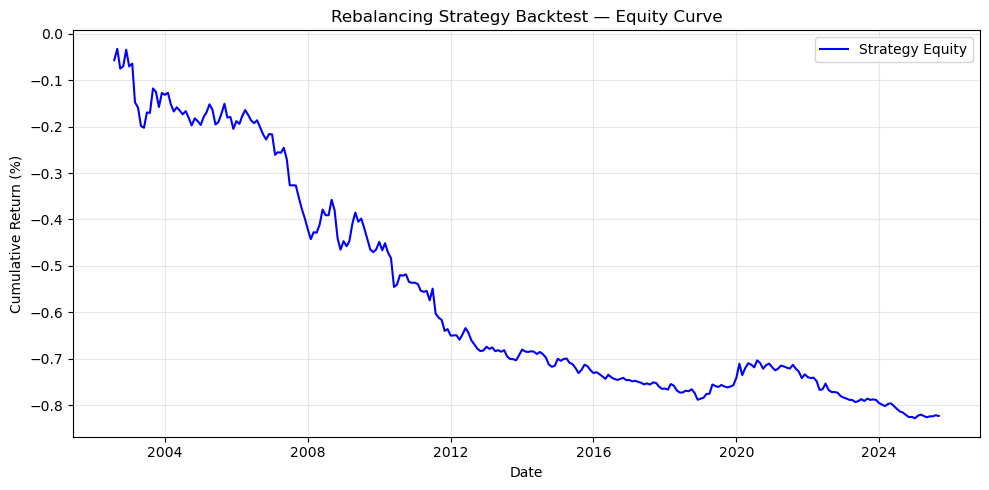

In [124]:
# When signal = +1 → SHORT SPY, LONG TLT → we expect SPY - TLT to fall
# When signal = -1 → LONG SPY, SHORT TLT → we expect SPY - TLT to rise
# We then use the "sum_of_spy__tlt_last_5_days" column as a "future return" (proxy of the trade outcome)

# initial_capital = 1000000  # $1,000,000 initial capital for the backtest

# add strategy_return column to monthly_periods dataframe
bt1['strategy_return'] = np.where(bt1['rebalancing_signal'] == 1,
                                               bt1['sum_of_spy__tlt_last_5_days'],
                                               -bt1['sum_of_spy__tlt_last_5_days'])

# calculate cumulative returns
bt1['cumulative_strategy_return'] = (1 + bt1['strategy_return']).cumprod() - 1

# calculate portfolio metrics
total_return = bt1['cumulative_strategy_return'].iloc[-1]
mean_return = bt1['strategy_return'].mean()
std_return = bt1['strategy_return'].std()
sharpe_ratio = (mean_return / std_return) * np.sqrt(12)

rf = 0.03 / 12  # 3% annuale
sharpe_ratio_rf = ((mean_return - rf) / std_return) * np.sqrt(12)

print("=== STRATEGY BACKTEST RESULTS ===")
print(f"Total Return: {total_return:.2%}")
print(f"Average Monthly Return: {mean_return:.2%}")
print(f"Sharpe Ratio (annualized): {sharpe_ratio:.2f}")
print(f"Sharpe Ratio with Risk-Free Rate (annualized): {sharpe_ratio_rf:.2f}")

# === Plot equity curve ===
plt.figure(figsize=(10,5))
plt.plot(bt1.index, bt1['cumulative_strategy_return'], label='Strategy Equity', color='blue')
plt.title("Rebalancing Strategy Backtest — Equity Curve")
plt.xlabel("Date")
plt.ylabel("Cumulative Return (%)")
plt.grid(True, alpha=0.3)
plt.legend()
plt.tight_layout()
plt.show()

In [125]:
bt1.head()

,sum_of_spy__tlt_first_15_days,sum_of_spy__tlt_last_5_days,sum_of_spy__tlt_first_5_days_next_month,rebalancing_signal,strategy_return,cumulative_strategy_return
date,,,,,,
2002-08-01,0.010151,-0.057039,-0.019438,1,-0.057039,-0.057039
2002-09-01,-0.126546,-0.025929,-0.028645,-1,0.025929,-0.032588
2002-10-01,0.160759,-0.044043,0.009031,1,-0.044043,-0.075196
2002-11-01,0.063586,0.005471,-0.032746,1,0.005471,-0.070136
2002-12-01,-0.064205,-0.038289,0.053190,-1,0.038289,-0.034533


## Backtest 2. LAST DAYS vs FIRST 5 DAYS NEXT MONTH

## Backtest 3. FIRST 15 DAYS vs FIRST 5 DAYS NEXT MONTH

In [127]:
# add signal column, when sum_of_spy__tlt_first_15_days > 0, signal = 1 (stocks outperform bonds), 
# else -1 (bonds outperform stocks)
bt3['rebalancing_signal'] = np.where(bt3['sum_of_spy__tlt_first_15_days'] > 0, 1, -1)

"""
In summary

The signal arises from the SPY–TLT divergence in the first 15 days of the month.

The signal anticipates the rebalancing flow (sale of the outperforming asset).

The backtest verifies whether the SPY–TLT spread moves in the expected direction 
in the first 5 days of the following month.
"""

'\nIn summary\n\nThe signal arises from the SPY–TLT divergence in the first 15 days of the month.\n\nThe signal anticipates the rebalancing flow (sale of the outperforming asset).\n\nThe backtest verifies whether the SPY–TLT spread moves in the expected direction \nin the first 5 days of the following month.\n'

=== STRATEGY BACKTEST RESULTS ===
Total Return: 678.29%
Average Monthly Return: 0.81%
Sharpe Ratio (annualized): 0.74
Sharpe Ratio with Risk-Free Rate (annualized): 0.51


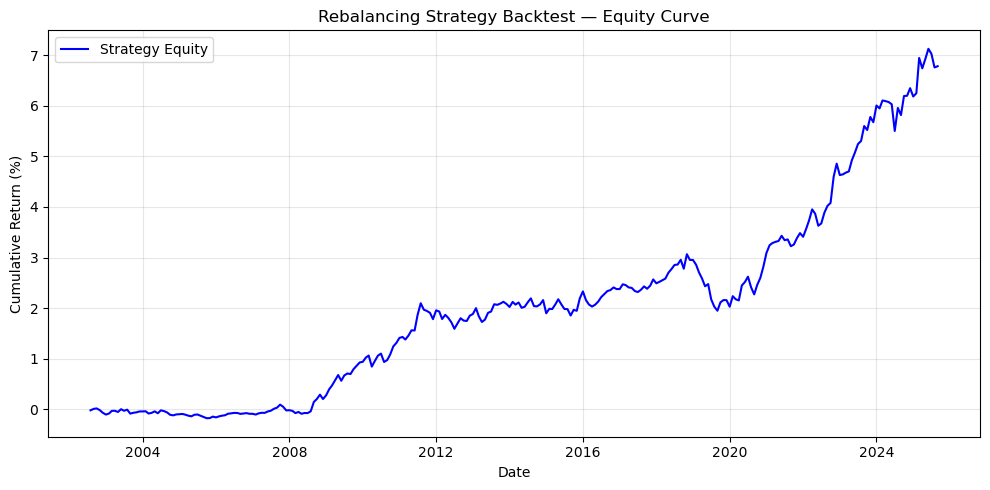

In [128]:
# When signal = +1 → SHORT SPY, LONG TLT → we expect SPY - TLT to fall
# When signal = -1 → LONG SPY, SHORT TLT → we expect SPY - TLT to rise
# We then use the "sum_of_spy__tlt_first_5_days_next_month" column as a "future return" (proxy of the trade outcome)

# initial_capital = 1000000  # $1,000,000 initial capital for the backtest

# add strategy_return column to monthly_periods dataframe
bt3['strategy_return'] = np.where(bt3['rebalancing_signal'] == 1,
                                               bt3['sum_of_spy__tlt_first_5_days_next_month'],
                                               -bt3['sum_of_spy__tlt_first_5_days_next_month'])

# calculate cumulative returns
bt3['cumulative_strategy_return'] = (1 + bt3['strategy_return']).cumprod() - 1

# calculate portfolio metrics
total_return = bt3['cumulative_strategy_return'].iloc[-1]
mean_return = bt3['strategy_return'].mean()
std_return = bt3['strategy_return'].std()
sharpe_ratio = (mean_return / std_return) * np.sqrt(12)

rf = 0.03 / 12  # 3% annuale
sharpe_ratio_rf = ((mean_return - rf) / std_return) * np.sqrt(12)

print("=== STRATEGY BACKTEST RESULTS ===")
print(f"Total Return: {total_return:.2%}")
print(f"Average Monthly Return: {mean_return:.2%}")
print(f"Sharpe Ratio (annualized): {sharpe_ratio:.2f}")
print(f"Sharpe Ratio with Risk-Free Rate (annualized): {sharpe_ratio_rf:.2f}")

# === Plot equity curve ===
plt.figure(figsize=(10,5))
plt.plot(bt3.index, bt3['cumulative_strategy_return'], label='Strategy Equity', color='blue')
plt.title("Rebalancing Strategy Backtest — Equity Curve")
plt.xlabel("Date")
plt.ylabel("Cumulative Return (%)")
plt.grid(True, alpha=0.3)
plt.legend()
plt.tight_layout()
plt.show()

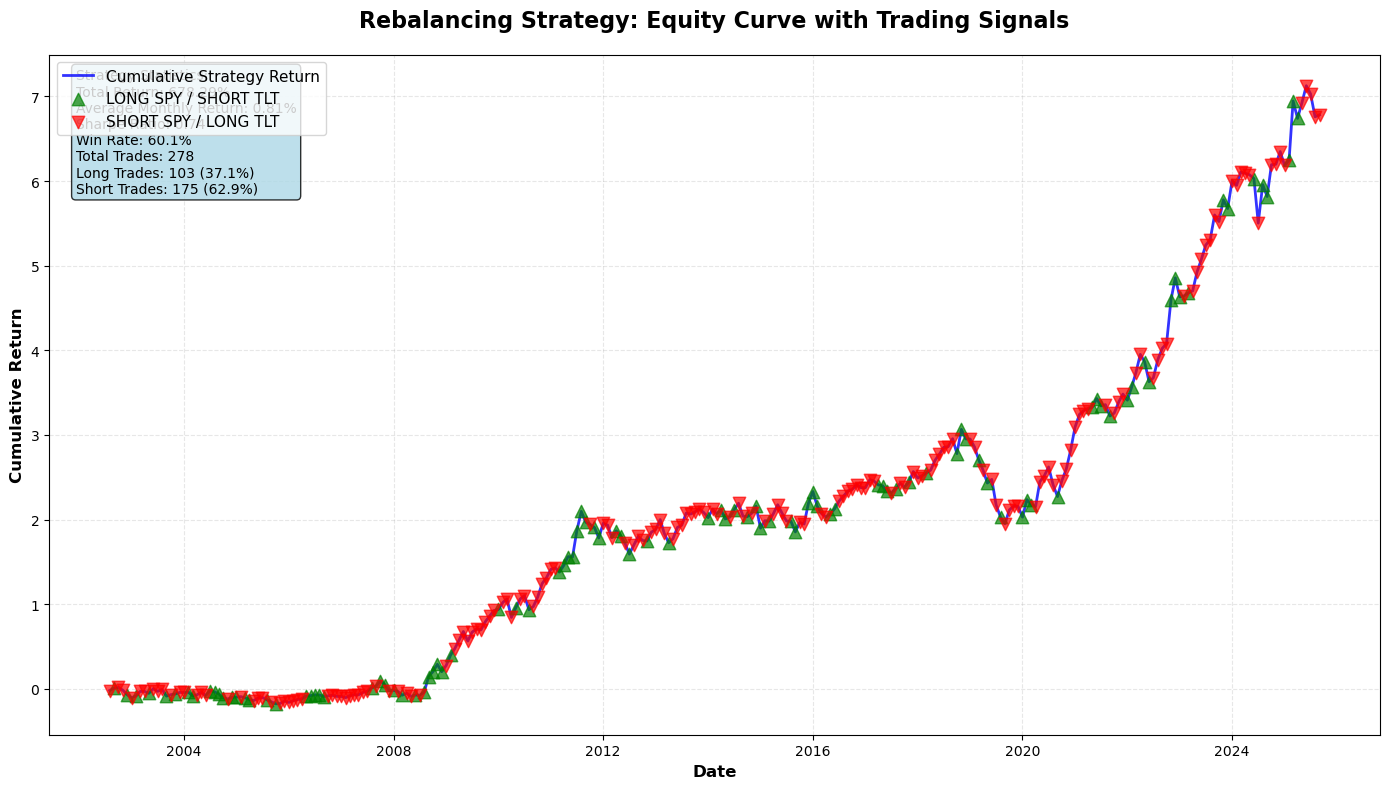

TRADING SIGNALS DISTRIBUTION
Total Observations: 278
Long SPY / Short TLT signals: 103 (37.1%)
Short SPY / Long TLT signals: 175 (62.9%)
Signal balance: 72 difference

LONG SPY / SHORT TLT Performance:
  Mean Return: 0.30%
  Std Dev: 4.65%
  Win Rate: 46.6%
  Best Month: 19.23%
  Worst Month: -8.25%

SHORT SPY / LONG TLT Performance:
  Mean Return: 1.11%
  Std Dev: 3.22%
  Win Rate: 68.0%
  Best Month: 9.37%
  Worst Month: -10.59%


In [129]:
# Visualization of Buy/Sell Signals on Equity Curve
plt.figure(figsize=(14, 8))

# Plot the main equity curve
plt.plot(bt3.index, bt3['cumulative_strategy_return'], 
         color='blue', label='Cumulative Strategy Return', linewidth=2, alpha=0.8)

# Create buy and sell signal datasets
buy_signals = bt3[bt3['rebalancing_signal'] == -1]  # LONG SPY / SHORT TLT
sell_signals = bt3[bt3['rebalancing_signal'] == 1]  # SHORT SPY / LONG TLT

# Plot buy signals (green up triangles)
plt.scatter(buy_signals.index, buy_signals['cumulative_strategy_return'], 
           marker='^', color='green', label='LONG SPY / SHORT TLT', s=80, alpha=0.7, zorder=5)

# Plot sell signals (red down triangles)
plt.scatter(sell_signals.index, sell_signals['cumulative_strategy_return'], 
           marker='v', color='red', label='SHORT SPY / LONG TLT', s=80, alpha=0.7, zorder=5)

# Formatting
plt.title('Rebalancing Strategy: Equity Curve with Trading Signals', 
          fontsize=16, fontweight='bold', pad=20)
plt.xlabel('Date', fontsize=12, fontweight='bold')
plt.ylabel('Cumulative Return', fontsize=12, fontweight='bold')
plt.legend(loc='upper left', fontsize=11)
plt.grid(True, alpha=0.3, linestyle='--')

# Add strategy statistics as text box
stats_text = f"""Strategy Statistics:
Total Return: {bt3['cumulative_strategy_return'].iloc[-1]:.2%}
Average Monthly Return: {bt3['strategy_return'].mean():.2%}
Sharpe Ratio: {(bt3['strategy_return'].mean() / bt3['strategy_return'].std()) * np.sqrt(12):.2f}
Win Rate: {(bt3['strategy_return'] > 0).mean():.1%}
Total Trades: {len(bt3)}
Long Trades: {len(buy_signals)} ({len(buy_signals)/len(bt3)*100:.1f}%)
Short Trades: {len(sell_signals)} ({len(sell_signals)/len(bt3)*100:.1f}%)"""

plt.text(0.02, 0.98, stats_text, transform=plt.gca().transAxes, 
         fontsize=10, verticalalignment='top', 
         bbox=dict(boxstyle='round', facecolor='lightblue', alpha=0.8))

plt.tight_layout()
plt.show()

# Print signal distribution summary
print("="*80)
print("TRADING SIGNALS DISTRIBUTION")
print("="*80)
print(f"Total Observations: {len(bt3)}")
print(f"Long SPY / Short TLT signals: {len(buy_signals)} ({len(buy_signals)/len(bt3)*100:.1f}%)")
print(f"Short SPY / Long TLT signals: {len(sell_signals)} ({len(sell_signals)/len(bt3)*100:.1f}%)")
print(f"Signal balance: {abs(len(buy_signals) - len(sell_signals))} difference")

# Performance by signal type
buy_performance = buy_signals['strategy_return'].describe()
sell_performance = sell_signals['strategy_return'].describe()

print(f"\nLONG SPY / SHORT TLT Performance:")
print(f"  Mean Return: {buy_performance['mean']:.2%}")
print(f"  Std Dev: {buy_performance['std']:.2%}")
print(f"  Win Rate: {(buy_signals['strategy_return'] > 0).mean():.1%}")
print(f"  Best Month: {buy_performance['max']:.2%}")
print(f"  Worst Month: {buy_performance['min']:.2%}")

print(f"\nSHORT SPY / LONG TLT Performance:")
print(f"  Mean Return: {sell_performance['mean']:.2%}")
print(f"  Std Dev: {sell_performance['std']:.2%}")
print(f"  Win Rate: {(sell_signals['strategy_return'] > 0).mean():.1%}")
print(f"  Best Month: {sell_performance['max']:.2%}")
print(f"  Worst Month: {sell_performance['min']:.2%}")
print("="*80)

### Additional Metrics

In [130]:
# def create_corrected_strategy_analysis_fixed(monthly_periods, initial_capital=1000000):
#     """
#     Function that provides strategy analysis with proper NaN handling
    
#     """
    
#     # Get the strategy returns
#     returns = monthly_periods['strategy_return']
    
#     # Remove any NaN values for calculations
#     clean_returns = returns.dropna()
    
#     if len(clean_returns) == 0:
#         return {"Error": "No valid returns data"}
    
#     # Basic statistics
#     mean_return = clean_returns.mean()
#     std_return = clean_returns.std()
    
#     # Calculate cumulative returns properly
#     cumulative_returns = (1 + clean_returns).cumprod()
#     final_cumulative_return = cumulative_returns.iloc[-1] - 1
    
#     # Performance metrics
#     total_return = final_cumulative_return  # CORRECTED
    
#     # Annualized return calculation
#     n_periods = len(clean_returns)
#     years = n_periods / 12
#     if years > 0 and total_return > -1:  # Avoid domain errors
#         annualized_return = (1 + total_return) ** (1 / years) - 1
#     else:
#         annualized_return = np.nan
    
#     # Volatility
#     annualized_volatility = std_return * np.sqrt(12) if not pd.isna(std_return) else np.nan
    
#     # Sharpe ratio
#     if std_return > 0 and not pd.isna(std_return):
#         sharpe_ratio = (mean_return / std_return) * np.sqrt(12)
#     else:
#         sharpe_ratio = np.nan
    
#     # Maximum drawdown calculation
#     cumulative_with_base = 1 + clean_returns.cumsum()  # Alternative calculation
#     running_max = cumulative_with_base.expanding().max()
#     drawdowns = (cumulative_with_base - running_max) / running_max
#     max_drawdown = drawdowns.min() if len(drawdowns) > 0 else np.nan
    
#     # Win rate
#     win_rate = (clean_returns > 0).mean() if len(clean_returns) > 0 else np.nan
    
#     # Value at Risk (95%)
#     var_95 = clean_returns.quantile(0.05) if len(clean_returns) > 0 else np.nan
    
#     # Format results with NaN handling
#     def format_pct(value):
#         if pd.isna(value) or np.isinf(value):
#             return "N/A"
#         return f"{value:.2%}"
    
#     def format_num(value, decimals=2):
#         if pd.isna(value) or np.isinf(value):
#             return "N/A"
#         return f"{value:.{decimals}f}"
    
#     results = {
#         'Total Return': format_pct(total_return),
#         'Annualized Return': format_pct(annualized_return),
#         'Average Monthly Return': format_pct(mean_return),
#         'Annualized Volatility': format_pct(annualized_volatility),
#         'Sharpe Ratio': format_num(sharpe_ratio),
#         'Maximum Drawdown': format_pct(max_drawdown),
#         'Win Rate': format_pct(win_rate),
#         'Value at Risk (95%)': format_pct(var_95),
#         'Number of Observations': len(clean_returns)
#     }
    
#     return results

# # fix actual strategy calculation
# print("="*80)
# print("STRATEGY BACKTEST RESULTS")
# print("="*80)

# # Fix the total return calculation in actual data
# final_cumulative_return = monthly_periods['cumulative_strategy_return'].iloc[-1]
# mean_return = monthly_periods['strategy_return'].mean()
# std_return = monthly_periods['strategy_return'].std()

# # Strategy calculations
# total_return_corrected = final_cumulative_return  # Remove the division by initial_capital
# sharpe_ratio = (mean_return / std_return) * np.sqrt(12)

# print("RESULTS:")
# print("-" * 40)
# print(f"Total Return:   {total_return_corrected:.2%}")
# print(f"Average Monthly Return:   {mean_return:.2%}")
# print(f"Sharpe Ratio:             {sharpe_ratio:.2f}")

# # Calculate additional metrics
# n_years = len(monthly_periods) / 12
# if total_return_corrected > -1:
#     annualized_return = (1 + total_return_corrected) ** (1/n_years) - 1
# else:
#     annualized_return = np.nan

# returns = monthly_periods['strategy_return']
# win_rate = (returns > 0).mean()
# var_95 = returns.quantile(0.05)

# print(f"Annualized Return:        {annualized_return:.2%}")
# print(f"Annualized Volatility:    {std_return * np.sqrt(12):.2%}")
# print(f"Win Rate:                 {win_rate:.2%}")
# print(f"Value at Risk (95%):      {var_95:.2%}")
# print(f"Number of Observations:   {len(monthly_periods)}")

# print(f"  Cumulative return: {final_cumulative_return:.4f} ({final_cumulative_return:.2%})")

# # Test with actual data using the fixed function
# print("\n" + "="*80)
# print("COMPREHENSIVE ANALYSIS WITH ACTUAL DATA")
# print("="*80)

# corrected_results = create_corrected_strategy_analysis_fixed(monthly_periods)

# for metric, value in corrected_results.items():
#     print(f"{metric:<25}: {value}")

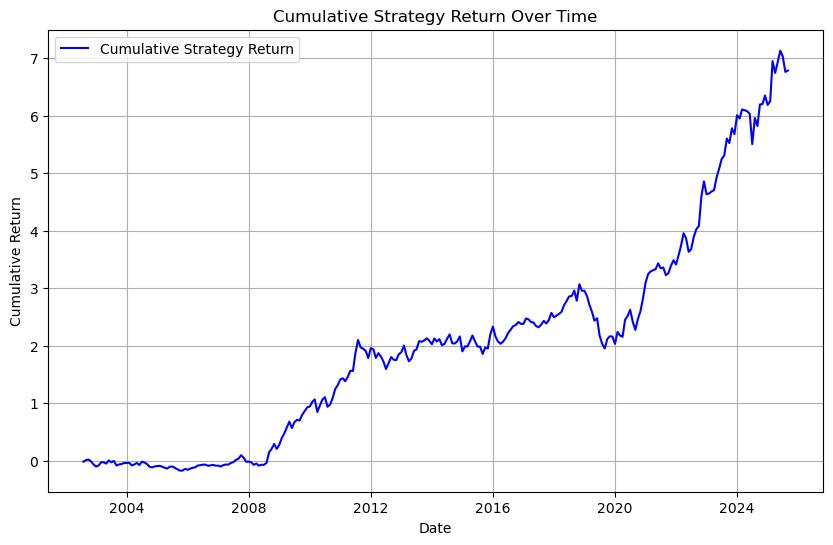

In [131]:
# plot final_cumulative_return
plt.figure(figsize=(10, 6))
plt.plot(bt3.index, bt3['cumulative_strategy_return'], color='blue', label='Cumulative Strategy Return')
plt.title('Cumulative Strategy Return Over Time')
plt.xlabel('Date')
plt.ylabel('Cumulative Return')
plt.legend()
plt.grid()
plt.show()